In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [203]:
dataset  = pd.read_csv('virtualInternshipData_ADS2001.csv', encoding = "ISO-8859-1")
dataset = dataset.dropna(subset=['RoleName'])
dataset = dataset.drop(columns = ['Unnamed: 0'])
dataset = dataset.reset_index()
filt_player = dataset['RoleName'] == 'Player'
player_df = dataset.loc[filt_player]

In [204]:
dataset['OutcomeScore'].value_counts()

OutcomeScore
4    8486
5    2450
2    2371
3    2350
6    1536
1     976
0     507
7     422
8      79
Name: count, dtype: int64

In [205]:
player_df = player_df.reset_index(drop = True)
player_df.dtypes

index                                     int64
userIDs                                   int64
implementation                           object
Line_ID                                   int64
ChatGroup                                object
content                                  object
group_id                                  int64
RoleName                                 object
roomName                                 object
m_experimental_testing                    int64
m_making_design_choices                   int64
m_asking_questions                        int64
j_customer_consultants_requests           int64
j_performance_parameters_requirements     int64
j_communication                           int64
OutcomeScore                              int64
wordCount                                 int64
dtype: object

In [206]:
len(player_df)

16902

In [207]:
import re
import nltk #imported to help us clean/remove any stop words that don't help with making predictions ex/the, and, I, we etc.
nltk.download('stopwords')#downloading all the stop words
from nltk.corpus import stopwords#importing all the stop words
from nltk.stem.porter import PorterStemmer #To keep the present tense (loved - love), if we 
#don't apply stemming then we will have one column for love and one column for loved, increasing the dimentionality of the 
#sparse matrix(matrix which most elements are 0, to allow for efficiency)
corpus = []
for i in range(0,16902): #iterates through all reviews (1000 reviews/entries in dataset)
    review = re.sub('[^a-zA-Z]', ' ', player_df['content'][i])#replaces everything that is not letters by a space, retrieving each value in review column
    review = review.lower() #makes all review values lowercase which is needed for stemming
    review = review.split() # splits review into different words which is needed for stemming
    ps = PorterStemmer() #creating an object to make words present tense
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') #not is a stopword but we want to keep not as it tells us a lot about the review so we remove it from 
    #all_stopwords then in next line choose all words that are not in all_stopwords
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)] #if the words are not stopwords, 
    #it will be considered in the for loop and those words will be converted into present tense (called stemming)
    review = ' '.join(review) #joins the words back to the string with a gap so words don't join togethera
    corpus.append(review) #adds each review into a list called corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [208]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def classify_statements(review):
    sentiment_score = sia.polarity_scores(review)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

player_df['sentiment'] = player_df['content'].apply(classify_statements)

player_df['positive'] = player_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
player_df['negative'] = player_df['sentiment'].apply(lambda x: 1 if x == 'negative' else 0)
player_df['neutral'] = player_df['sentiment'].apply(lambda x: 1 if x == 'neutral' else 0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aryak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [209]:
X = player_df[['implementation','ChatGroup', 'roomName', 'sentiment','m_experimental_testing', 'm_making_design_choices', 'm_asking_questions', 
                'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication', 'wordCount']] #rmb about content later
y = player_df['OutcomeScore']


In [211]:
type(X)

pandas.core.frame.DataFrame

In [212]:
X.shape

(16902, 11)

In [213]:
np.unique

<function unique at 0x0000023635D1E130>

In [214]:
X.columns


Index(['implementation', 'ChatGroup', 'roomName', 'sentiment',
       'm_experimental_testing', 'm_making_design_choices',
       'm_asking_questions', 'j_customer_consultants_requests',
       'j_performance_parameters_requirements', 'j_communication',
       'wordCount'],
      dtype='object')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['RoleName'] = le.fit_transform(X['RoleName'])

In [215]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,2,3])], remainder='passthrough')
X = ct.fit_transform(X)

In [216]:
X = X.toarray()

In [217]:
X.shape

(16902, 40)

In [222]:
y.shape

(16902,)


player_df_copy = player_df.copy()
mean_scores = player_df_copy.groupby('userIDs')['OutcomeScore'].mean().reset_index()

count_scores1 = player_df_copy.groupby('userIDs')['m_experimental_testing'].sum().reset_index()
count_scores2 = player_df_copy.groupby('userIDs')['m_making_design_choices'].sum().reset_index()
count_scores3 = player_df_copy.groupby('userIDs')['m_asking_questions'].sum().reset_index()
count_scores4 = player_df_copy.groupby('userIDs')['j_customer_consultants_requests'].sum().reset_index()
count_scores5 = player_df_copy.groupby('userIDs')['j_performance_parameters_requirements'].sum().reset_index()
count_scores6 = player_df_copy.groupby('userIDs')['j_communication'].sum().reset_index()
player_df_copy = player_df_copy.merge(mean_scores, on='userIDs', suffixes=('', '_mean'))
player_df_copy = player_df_copy.merge(count_scores1, on='userIDs', suffixes=('', '_sum'))
player_df_copy = player_df_copy.merge(count_scores2, on='userIDs', suffixes=('', '_sum'))
player_df_copy = player_df_copy.merge(count_scores3, on='userIDs', suffixes=('', '_sum'))
player_df_copy = player_df_copy.merge(count_scores4, on='userIDs', suffixes=('', '_sum'))
player_df_copy = player_df_copy.merge(count_scores5, on='userIDs', suffixes=('', '_sum'))
player_df_copy = player_df_copy.merge(count_scores6, on='userIDs', suffixes=('', '_sum'))

player_df_copy



deduplicated_df = player_df_copy.groupby('userIDs').agg({
    'OutcomeScore': 'mean',
    'm_experimental_testing': 'sum',
    'm_making_design_choices': 'sum',
    'm_asking_questions': 'sum',
    'j_customer_consultants_requests': 'sum',
    'j_performance_parameters_requirements': 'sum',
    'j_communication': 'sum',
    'content': lambda x: ' '.join(x)
}).reset_index()
deduplicated_df = pd.DataFrame(deduplicated_df)

deduplicated_df


deduplicated_df['binary_score'] = np.where(deduplicated_df['OutcomeScore'] >= 6, 1, 0)
# Assign the list to a new column
'''
X = deduplicated_df[['m_experimental_testing', 'm_making_design_choices', 'm_asking_questions', 
                'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication']]
y = deduplicated_df['binary_score']
'''

In [223]:
y.shape

(16902,)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [224]:

userIDs = player_df['userIDs'].values
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

gkf = GroupKFold(n_splits=5)

for train_idx, test_idx in gkf.split(X, y, groups=userIDs):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [225]:
X_train

array([[1., 0., 0., ..., 0., 0., 4.],
       [1., 0., 0., ..., 0., 0., 3.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [226]:
type(y_train)

pandas.core.series.Series

from seaborn import sns
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=9, discrete=True, color='skyblue', edgecolor='black')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Outcome Score")
plt.ylabel("Frequency")
plt.xticks(range(9))
plt.tight_layout()
plt.show()

In [227]:

from imblearn.over_sampling import SMOTE
oversample=SMOTE(random_state = 42)
X_train,y_train=oversample.fit_resample(X_train,y_train)

'\nfrom imblearn.over_sampling import ADASYN\n\n# Assuming X and y are your training features and labels\nadasyn = ADASYN(random_state=42)\nX_train, y_train = adasyn.fit_resample(X_train, y_train)\n'

plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=9, discrete=True, color='skyblue', edgecolor='black')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Outcome Score")
plt.ylabel("Frequency")
plt.xticks(range(9))
plt.tight_layout()
plt.show()

In [228]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

In [229]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [230]:
len(X_train)

43155

In [231]:
len(y_train)

43155

In [232]:
from xgboost import XGBClassifier 
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score
y_pred_classes = np.argmax(y_pred, axis=1) #returns index of max value (convers [0,1,0] to 1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
accuracy = accuracy_score(y_test_classes, y_pred_classes)


In [233]:
cm

array([[  0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  5,   0,   4,  10,  96,   0,   0,   0,   0],
       [ 93,  12,  32,  29, 134,  51,  19,   0,   0],
       [199,  12,  68,  12,  48,  77,  36,   0,   0],
       [317, 217, 122, 137, 500,  32,  82,   9,   0],
       [128,  90,   9,   5, 193,  75, 134,  20,   0],
       [111,   0,  83,  29,  17,  41,  43,   8,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 18,   0,   0,   0,   8,   4,   0,   9,   0]], dtype=int64)

In [234]:
accuracy

0.19591595146493046

In [235]:
import tensorflow as tf

In [236]:
(X_train.shape[1])

40

In [237]:
X_df = pd.DataFrame(X)
X_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
16899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [440]:
import random
import os

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [441]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout



gkf = GroupKFold(n_splits=10)
groups = player_df['userIDs'].values
histories = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n Training Fold {fold + 1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]  


    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)


    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val, num_classes=9)

    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                                  kernel_regularizer=regularizers.l2(0.001)))
    #tf.keras.layers.Dropout(0.2)
    ann.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #tf.keras.layers.Dropout(0.2)
    ann.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #tf.keras.layers.Dropout(0.2)
    ann.add(tf.keras.layers.Dense(9, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    ann.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = ann.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=64, epochs=100,
                      callbacks=[early_stopping])
    histories.append(history)


🔁 Training Fold 1
Epoch 1/100


C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5437 - loss: 1.3656 - val_accuracy: 0.2893 - val_loss: 3.4353
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6436 - loss: 1.0420 - val_accuracy: 0.2888 - val_loss: 3.3925
Epoch 3/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6522 - loss: 1.0146 - val_accuracy: 0.2692 - val_loss: 3.5315
Epoch 4/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6551 - loss: 1.0003 - val_accuracy: 0.2396 - val_loss: 3.6763
Epoch 5/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6549 - loss: 0.9981 - val_accuracy: 0.2568 - val_loss: 3.7401
Epoch 6/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6515 - loss: 0.9843 - val_accuracy: 0.2947 - val_loss: 3.5890
Epoch 7/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6535 - loss: 0.9784 - val_accuracy: 0.2686 - val_loss: 4.0393
Epoch 8/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6571 - loss: 0.9780 - val_accuracy: 0.3006

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5621 - loss: 1.3196 - val_accuracy: 0.1649 - val_loss: 5.3393
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6599 - loss: 1.0141 - val_accuracy: 0.1714 - val_loss: 5.5183
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6661 - loss: 0.9881 - val_accuracy: 0.1590 - val_loss: 5.7879
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6696 - loss: 0.9640 - val_accuracy: 0.1850 - val_loss: 5.9553
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6697 - loss: 0.9544 - val_accuracy: 0.1826 - val_loss: 6.3434
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6724 - loss: 0.9494 - val_accuracy: 0.1903 - val_loss: 5.7602
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6744 - loss: 0.9363 - val_accuracy: 0.1879 - val_loss: 5.9195
Epoch 8/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6710 - loss: 0.9364 - val_accuracy: 0.1915

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


760/760 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5358 - loss: 1.3841 - val_accuracy: 0.3097 - val_loss: 2.9578
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6305 - loss: 1.0830 - val_accuracy: 0.3499 - val_loss: 3.1160
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6369 - loss: 1.0538 - val_accuracy: 0.3221 - val_loss: 2.9060
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6383 - loss: 1.0435 - val_accuracy: 0.3357 - val_loss: 3.1478
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6426 - loss: 1.0270 - val_accuracy: 0.3097 - val_loss: 3.2298
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6423 - loss: 1.0264 - val_accuracy: 0.3120 - val_loss: 3.2676
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6470 - loss: 1.0080 - val_accuracy: 0.3375 - val_loss: 3.1958
Epoch 8/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6453 - loss: 1.0049 - val_accuracy: 0.3114

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5780 - loss: 1.3177 - val_accuracy: 0.2479 - val_loss: 3.9721
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6704 - loss: 1.0121 - val_accuracy: 0.2609 - val_loss: 3.6832
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6766 - loss: 0.9852 - val_accuracy: 0.2876 - val_loss: 3.9968
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6774 - loss: 0.9723 - val_accuracy: 0.2740 - val_loss: 4.2237
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6784 - loss: 0.9629 - val_accuracy: 0.2846 - val_loss: 4.2011
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6803 - loss: 0.9568 - val_accuracy: 0.2899 - val_loss: 4.0520
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6812 - loss: 0.9522 - val_accuracy: 0.2763 - val_loss: 4.3407
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6831 - loss: 0.9464 - val_accuracy: 0.2870

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5379 - loss: 1.3974 - val_accuracy: 0.1892 - val_loss: 2.8623
Epoch 2/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6416 - loss: 1.0736 - val_accuracy: 0.1549 - val_loss: 3.2244
Epoch 3/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6483 - loss: 1.0447 - val_accuracy: 0.1993 - val_loss: 2.9401
Epoch 4/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6482 - loss: 1.0307 - val_accuracy: 0.1685 - val_loss: 3.2433
Epoch 5/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6505 - loss: 1.0184 - val_accuracy: 0.1750 - val_loss: 3.2421
Epoch 6/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6503 - loss: 1.0145 - val_accuracy: 0.1674 - val_loss: 3.3037
Epoch 7/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6538 - loss: 0.9989 - val_accuracy: 0.1904 - val_loss: 3.3984
Epoch 8/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6522 - loss: 0.9971 - val_accuracy: 0.2099

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5695 - loss: 1.3127 - val_accuracy: 0.1740 - val_loss: 3.7421
Epoch 2/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6646 - loss: 1.0061 - val_accuracy: 0.1834 - val_loss: 3.7734
Epoch 3/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6674 - loss: 0.9838 - val_accuracy: 0.1817 - val_loss: 4.1513
Epoch 4/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6707 - loss: 0.9616 - val_accuracy: 0.2012 - val_loss: 4.1246
Epoch 5/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6689 - loss: 0.9543 - val_accuracy: 0.2195 - val_loss: 4.0820
Epoch 6/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6723 - loss: 0.9490 - val_accuracy: 0.1911 - val_loss: 4.2326
Epoch 7/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6749 - loss: 0.9369 - val_accuracy: 0.1917 - val_loss: 4.5907
Epoch 8/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6713 - loss: 0.9382 - val_accuracy: 0.1834

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5515 - loss: 1.3436 - val_accuracy: 0.2193 - val_loss: 4.0297
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6394 - loss: 1.0460 - val_accuracy: 0.2051 - val_loss: 3.8041
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6455 - loss: 1.0116 - val_accuracy: 0.2193 - val_loss: 4.0111
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6507 - loss: 0.9973 - val_accuracy: 0.1856 - val_loss: 4.3912
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6556 - loss: 0.9844 - val_accuracy: 0.2370 - val_loss: 4.2010
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6549 - loss: 0.9790 - val_accuracy: 0.2358 - val_loss: 4.5916
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6575 - loss: 0.9745 - val_accuracy: 0.2110 - val_loss: 4.1593
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6557 - loss: 0.9716 - val_accuracy: 0.2204

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


805/805 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5351 - loss: 1.3908 - val_accuracy: 0.2374 - val_loss: 3.1246
Epoch 2/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6329 - loss: 1.0729 - val_accuracy: 0.2587 - val_loss: 3.3803
Epoch 3/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6423 - loss: 1.0343 - val_accuracy: 0.2528 - val_loss: 3.3041
Epoch 4/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6440 - loss: 1.0174 - val_accuracy: 0.2404 - val_loss: 3.6603
Epoch 5/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6434 - loss: 1.0125 - val_accuracy: 0.2611 - val_loss: 3.8152
Epoch 6/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6487 - loss: 0.9997 - val_accuracy: 0.2374 - val_loss: 3.7120
Epoch 7/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6525 - loss: 0.9899 - val_accuracy: 0.2546 - val_loss: 3.8315
Epoch 8/100
805/805 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6516 - loss: 0.9945 - val_accuracy: 0.2404

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5536 - loss: 1.3530 - val_accuracy: 0.1367 - val_loss: 3.4199
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6472 - loss: 1.0426 - val_accuracy: 0.1396 - val_loss: 3.7248
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6486 - loss: 1.0184 - val_accuracy: 0.1799 - val_loss: 3.7664
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6523 - loss: 1.0046 - val_accuracy: 0.1391 - val_loss: 3.6037
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6570 - loss: 0.9926 - val_accuracy: 0.1361 - val_loss: 3.9831
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6578 - loss: 0.9822 - val_accuracy: 0.1598 - val_loss: 4.0129
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6587 - loss: 0.9795 - val_accuracy: 0.1556 - val_loss: 3.6913
Epoch 8/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6597 - loss: 0.9731 - val_accuracy: 0.1456

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5521 - loss: 1.3521 - val_accuracy: 0.1829 - val_loss: 3.0738
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6486 - loss: 1.0502 - val_accuracy: 0.1871 - val_loss: 3.2516
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6527 - loss: 1.0194 - val_accuracy: 0.2031 - val_loss: 3.2592
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6580 - loss: 1.0080 - val_accuracy: 0.1841 - val_loss: 3.5125
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6590 - loss: 0.9946 - val_accuracy: 0.2179 - val_loss: 3.5907
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6587 - loss: 0.9927 - val_accuracy: 0.1758 - val_loss: 3.6961
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6611 - loss: 0.9850 - val_accuracy: 0.1764 - val_loss: 3.4712
Epoch 8/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6611 - loss: 0.9805 - val_accuracy: 0.2013

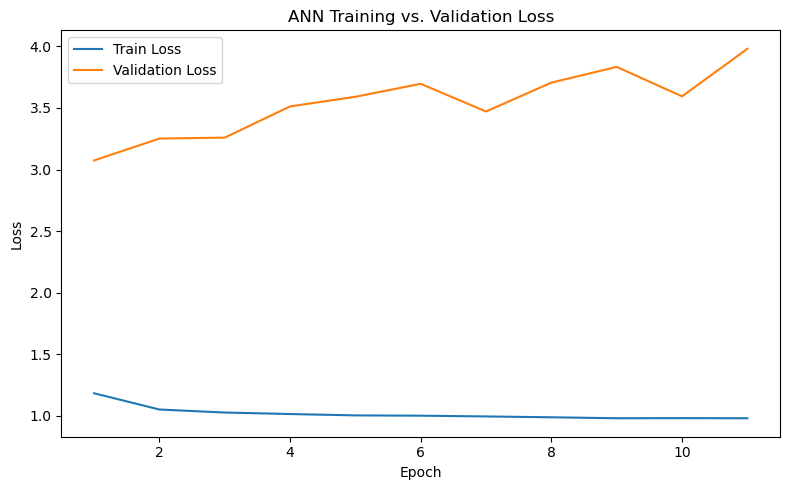

In [442]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
epochs     = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss,   label='Validation Loss')
plt.title('ANN Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [443]:
ann.summary()

Model: "sequential_383"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1532 (Dense)              │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1533 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1534 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1535 (Dense)              │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,173 (70.99 KB)

 Trainable params: 6,057 (23.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,116 (47.33 KB)

In [444]:
y_pred = ann.predict(X_test)
loss, test_acc = ann.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)
train_loss, train_acc = ann.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = ann.evaluate(X_val, y_val, verbose=0)

print(f"Fold {fold+1} - Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4844 - loss: 1.5494
Test Accuracy: 0.4977804124355316
Fold 10 - Train Accuracy: 0.6549 | Val Accuracy: 0.1829


'''
importances_std = result.importances_std
importances_mean = result.importances_mean
import matplotlib.pyplot as plt

indices = np.argsort(importances_mean)[::-1]  # sort features by importance

plt.figure(figsize=(12, 5))
plt.title("Permutation Feature Importance (ANN)")
plt.bar(range(len(importances_mean)), importances_mean[indices],
        yerr=importances_std[indices], capsize=4)
plt.xlabel("Feature Index")
plt.ylabel("Mean Accuracy Drop")
plt.show()
indices
'''

'''
from sklearn.inspection import permutation_importance
y_val_int = np.argmax(y_val, axis=1)

def keras_accuracy(model, X, y_true):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    return accuracy_score(y_true, y_pred)

# Run permutation importance
result = permutation_importance(
    estimator=ann,
    X=X_val,
    y=y_val_int,
    scoring=keras_accuracy,
    n_repeats=10,
    random_state=42
)
result
'''

In [445]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
y_pred_classes = np.argmax(y_pred, axis=1) #retuerns index of max value (convers [0,1,0] to 1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average = 'macro')
recall = recall_score(y_test_classes, y_pred_classes, average = 'macro')
f1 = f1_score(y_test_classes, y_pred_classes, average = 'macro')

C:\Users\aryak\Downloads\Anaconda Monash\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [446]:

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.384
Recall: 0.441
F1 Score: 0.379
Accuracy: 0.498


In [447]:
#£report_df = pd.DataFrame(report)

type(report)

In [448]:
cm

array([[  0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,  80,  17,   0,  18,   0,   0,   0,   0],
       [  0,  25, 172,  41,  19,  82,  31,   0,   0],
       [ 53,   6,  13, 233,  34,  13,  99,   1,   0],
       [ 95, 116,  67, 149, 737,  46, 159,  17,  30],
       [  1,  83,  11,  25,  94, 245, 132,  41,  22],
       [ 51,   4,  21,  28,   1,   1, 182,  44,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   6,  33]], dtype=int64)

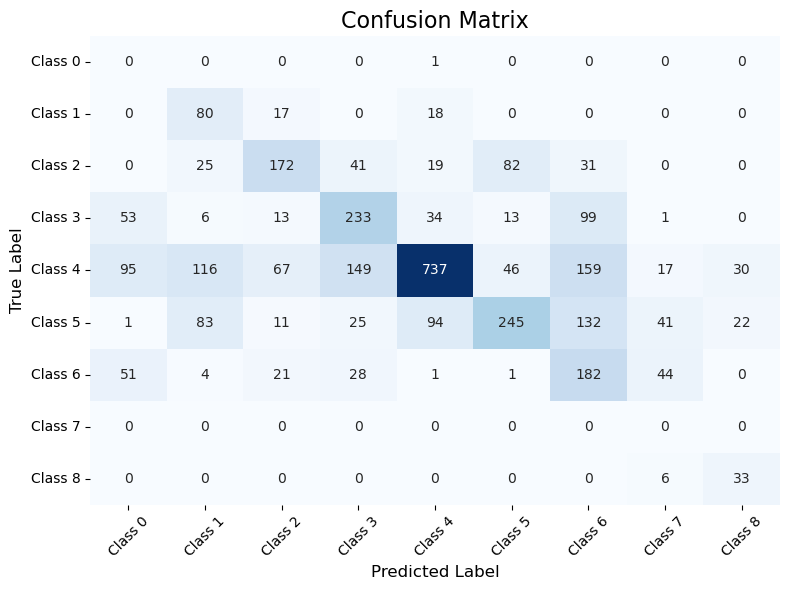

In [449]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(9)],
            yticklabels=[f'Class {i}' for i in range(9)])

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [250]:
accuracy.

SyntaxError: invalid syntax (3721390040.py, line 1)

In [ ]:
X_test.shape


In [ ]:
#y_test = y_test.to_numpy() 
#np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)

In [ ]:
y_pred

In [ ]:
y_test.dtype

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1) #retuerns index of max value (convers [0,1,0] to 1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
accuracy = accuracy_score(y_test_classes, y_pred_classes)

In [ ]:
cm

In [ ]:
accuracy

In [ ]:
y_pred.shape

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)


In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
ann = KerasClassifier(neurons = 32, layers = 1, build_fn=ann, epochs=50, batch_size=32, verbose=0)
#from sklearn.model_selection import cross_val_score
#accuracies = cross_val_score(estimator = ann, X = X_train, y = y_train, cv = 3, scoring = 'accuracy')
#print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
#print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
#ann = KerasClassifier(build_fn=ann, verbose=0)

from sklearn.model_selection import GridSearchCV
parameters = {
    'neurons': [16, 32, 64, 128],
    'layers': [1, 2, 3],
    'epochs': [50, 100]
}
#because we check 2 different kernels as gamma parameter is only in a rbf kernel 
grid_search = GridSearchCV(estimator = ann, param_grid = parameters, 
                           scoring = 'accuracy', cv = 3, 
                          n_jobs = -1) #each of the combinations of hyperparameters are evaluated through k-fold cross validations, njobs = -1 uses all cpus
grid_search.fit(X_train,y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters", best_parameters)

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 20, kernel = 'rbf', fit_inverse_transform=True)
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# If y_train is one-hot, decode it first
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train  # Already class labels (0–8)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_train[:, 0], 
    y=X_train[:, 1], 
    hue=y_train_labels,  # Plot color by class
    palette='tab10', 
    s=60,
    edgecolor='black'
)

plt.title('Kernel PCA Projection (Train Set)', fontsize=16)
plt.xlabel('First KPCA Component', fontsize=12)
plt.ylabel('Second KPCA Component', fontsize=12)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(kpca.eigenvalues_)

In [ ]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
'''
y_train = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights_array))
'''
# Convert labels to categorical (required by softmax + categorical_crossentropy)
y_encoded = to_categorical(y, num_classes=9)

# Define the group IDs
groups = player_df['userIDs'].values

# Prepare the splitter
gkf = GroupKFold(n_splits=10)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y_encoded, groups=groups)):
    print(f"\n🔁 Training Fold {fold + 1}")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # Define model architecture again (new model for each fold)
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],),
                                  kernel_regularizer=regularizers.l2(0.001)))
    ann.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #ann.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    ann.add(tf.keras.layers.Dense(9, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    ann.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train
    history = ann.fit(X_train, y_train,
                      #validation_data=(X_val, y_val),
                      batch_size=64, epochs=100,
                      callbacks=[early_stopping], validation_split = 0.1)


In [ ]:
y_pred = ann.predict(X_test)
loss, test_acc = ann.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
y_pred_classes = np.argmax(y_pred, axis=1) #retuerns index of max value (convers [0,1,0] to 1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average = 'macro')
recall = recall_score(y_test_classes, y_pred_classes, average = 'macro')
f1 = f1_score(y_test_classes, y_pred_classes, average = 'macro')

In [ ]:
accuracy

In [ ]:
y_pred = ann.predict(X_test)
loss, test_acc = ann.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()